In [151]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from statsmodels.graphics.tsaplots import plot_pacf

<h2>1. Data ARE-Historical-Data-final

In [152]:
# Import data
df = pd.read_csv('ARE-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df1=df.reset_index()['Price']

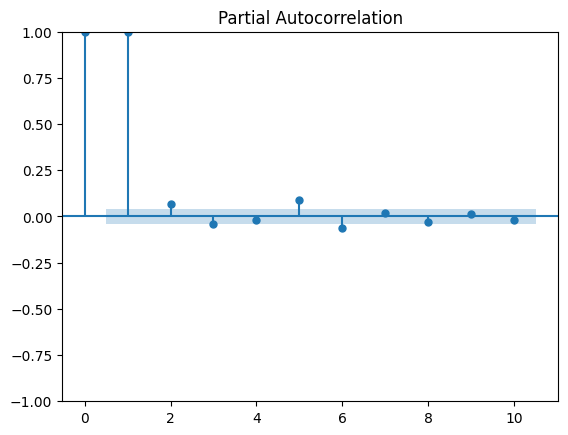

In [153]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=10)
plt.show()

In [154]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [155]:
# Chia thành các tập train, test, validation
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [156]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [157]:
# Thiết lập thông số mô hình
lookback = 5
horizon = 1
n_features = 1

In [158]:
# Tạo dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [159]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [160]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50


47/47 - 3s - loss: 0.0223 - val_loss: 0.0015 - 3s/epoch - 67ms/step
Epoch 2/50
47/47 - 0s - loss: 0.0011 - val_loss: 0.0010 - 262ms/epoch - 6ms/step
Epoch 3/50
47/47 - 0s - loss: 4.3714e-04 - val_loss: 0.0011 - 233ms/epoch - 5ms/step
Epoch 4/50
47/47 - 0s - loss: 4.2362e-04 - val_loss: 9.7432e-04 - 213ms/epoch - 5ms/step
Epoch 5/50
47/47 - 0s - loss: 4.2384e-04 - val_loss: 0.0010 - 226ms/epoch - 5ms/step
Epoch 6/50
47/47 - 0s - loss: 4.1119e-04 - val_loss: 9.3186e-04 - 242ms/epoch - 5ms/step
Epoch 7/50
47/47 - 0s - loss: 4.0161e-04 - val_loss: 9.2321e-04 - 215ms/epoch - 5ms/step
Epoch 8/50
47/47 - 0s - loss: 4.0095e-04 - val_loss: 9.8953e-04 - 225ms/epoch - 5ms/step
Epoch 9/50
47/47 - 0s - loss: 3.9691e-04 - val_loss: 9.1894e-04 - 210ms/epoch - 4ms/step
Epoch 10/50
47/47 - 0s - loss: 3.8963e-04 - val_loss: 9.0109e-04 - 205ms/epoch - 4ms/step
Epoch 11/50
47/47 - 0s - loss: 3.8733e-04 - val_loss: 9.3820e-04 - 197ms/epoch - 4ms/step
Epoch 12/50
47/47 - 0s - loss: 3.8783e-04 - val_loss: 0.

In [161]:
# Dự đoán trên 2 tập X_test và X_val
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [162]:
# Scaler lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
y_val=scaler.inverse_transform(y_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [163]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.9585781620887692
Testing RMSE: 5.445302684823504
Testing MAE: 4.586846030099051
Validation MAE: 3.09723064513868
Testing MAPE: 2.491427655881602
Validation MAPE: 2.203908154151459


In [164]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [165]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


In [166]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

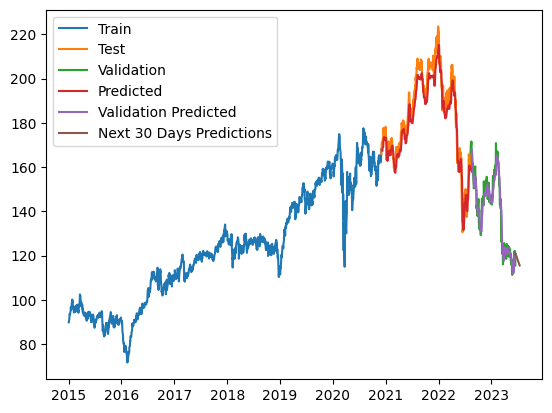

In [167]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()

<h2>2. Data ARI-Historical-Data-final

In [168]:
# Import data
df = pd.read_csv('ARI-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df1=df.reset_index()['Price']

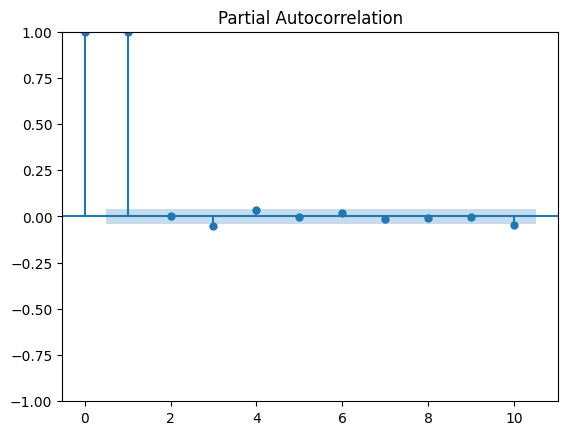

In [169]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=10)
plt.show()

In [170]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [171]:
# Chia thành các tập train, test, validation
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [172]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [173]:
# Chọn các giá trị lookback, horizon, n_features
lookback = 3
horizon = 1
n_features = 1

In [174]:
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [175]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [176]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
47/47 - 3s - loss: 0.2132 - val_loss: 0.0134 - 3s/epoch - 65ms/step
Epoch 2/50
47/47 - 0s - loss: 0.0057 - val_loss: 0.0152 - 178ms/epoch - 4ms/step
Epoch 3/50
47/47 - 0s - loss: 0.0033 - val_loss: 0.0092 - 171ms/epoch - 4ms/step
Epoch 4/50
47/47 - 0s - loss: 0.0023 - val_loss: 0.0056 - 161ms/epoch - 3ms/step
Epoch 5/50
47/47 - 0s - loss: 0.0015 - val_loss: 0.0028 - 201ms/epoch - 4ms/step
Epoch 6/50
47/47 - 0s - loss: 0.0011 - val_loss: 0.0014 - 279ms/epoch - 6ms/step
Epoch 7/50
47/47 - 0s - loss: 8.1682e-04 - val_loss: 8.8038e-04 - 237ms/epoch - 5ms/step
Epoch 8/50
47/47 - 0s - loss: 7.1710e-04 - val_loss: 7.2851e-04 - 230ms/epoch - 5ms/step
Epoch 9/50
47/47 - 0s - loss: 6.8547e-04 - val_loss: 6.9608e-04 - 246ms/epoch - 5ms/step
Epoch 10/50
47/47 - 0s - loss: 6.8969e-04 - val_loss: 7.1181e-04 - 242ms/epoch - 5ms/step
Epoch 11/50
47/47 - 0s - loss: 6.8296e-04 - val_loss: 6.9187e-04 - 227ms/epoch - 5ms/step
Epoch 12/50
47/47 - 0s - loss: 6.7816e-04 - val_loss: 7.2254e-04 - 24

In [177]:
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

7/7 [==============================] - 0s 1ms/step


In [178]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
y_val=scaler.inverse_transform(y_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [179]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.40101101707217107
Testing RMSE: 0.3594613618627089
Testing MAE: 0.2910684060372449
Validation MAE: 0.30016798932405453
Testing MAPE: 2.1907333373007836
Validation MAPE: 2.8326426693578335


In [180]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [181]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


In [182]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

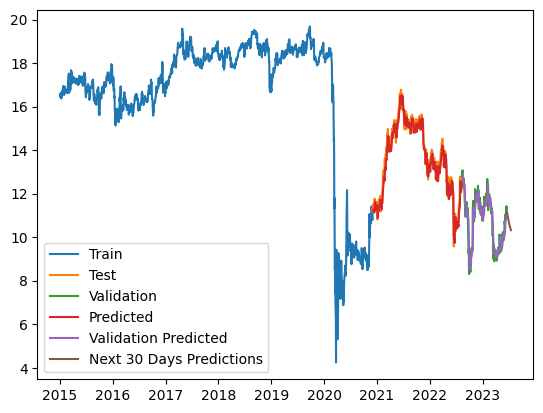

In [183]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()

<h2>3. Data MAA-Historical-Data-final

In [184]:
# Import data
df = pd.read_csv('MAA-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df1=df.reset_index()['Price']

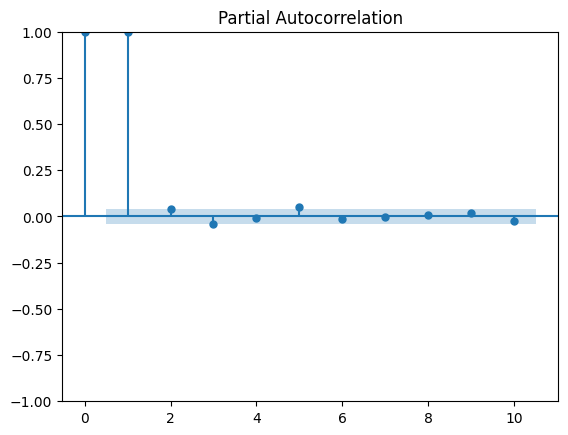

In [185]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=10)
plt.show()

In [186]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [187]:
# Chia thành các tập train, test, validation
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [188]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [189]:
# Thiết lập thông số mô hình
lookback = 5
horizon = 1
n_features = 1

In [190]:
# Tạo dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [191]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [192]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
47/47 - 4s - loss: 0.0100 - val_loss: 0.0075 - 4s/epoch - 75ms/step
Epoch 2/50
47/47 - 0s - loss: 6.8233e-04 - val_loss: 0.0037 - 233ms/epoch - 5ms/step
Epoch 3/50
47/47 - 0s - loss: 3.7061e-04 - val_loss: 0.0013 - 249ms/epoch - 5ms/step
Epoch 4/50
47/47 - 0s - loss: 3.7180e-04 - val_loss: 0.0015 - 217ms/epoch - 5ms/step
Epoch 5/50
47/47 - 0s - loss: 3.6809e-04 - val_loss: 7.9156e-04 - 241ms/epoch - 5ms/step
Epoch 6/50
47/47 - 0s - loss: 3.7659e-04 - val_loss: 0.0014 - 260ms/epoch - 6ms/step
Epoch 7/50
47/47 - 0s - loss: 3.4435e-04 - val_loss: 0.0014 - 219ms/epoch - 5ms/step
Epoch 8/50
47/47 - 0s - loss: 3.6308e-04 - val_loss: 7.0547e-04 - 254ms/epoch - 5ms/step
Epoch 9/50
47/47 - 0s - loss: 3.5329e-04 - val_loss: 6.8729e-04 - 259ms/epoch - 6ms/step
Epoch 10/50
47/47 - 0s - loss: 3.3651e-04 - val_loss: 6.5455e-04 - 257ms/epoch - 5ms/step
Epoch 11/50
47/47 - 0s - loss: 3.2964e-04 - val_loss: 6.3832e-04 - 246ms/epoch - 5ms/step
Epoch 12/50
47/47 - 0s - loss: 3.3535e-04 - val_l

In [193]:

y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [194]:
#Scale lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
y_val=scaler.inverse_transform(y_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [195]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 4.318409186560088
Testing RMSE: 9.445395387240637
Testing MAE: 7.899173122587657
Validation MAE: 3.6187170877411066
Testing MAPE: 4.117428037112787
Validation MAPE: 2.277004530180137


In [196]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [197]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


In [198]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

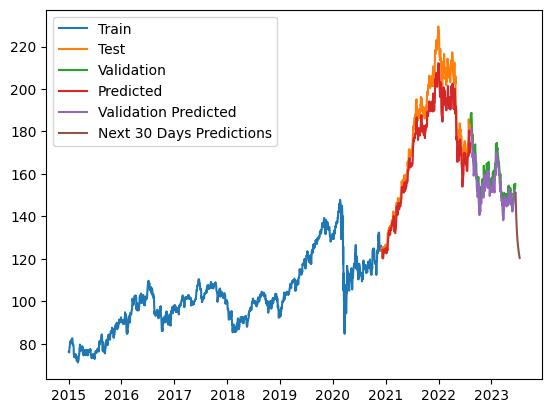

In [199]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()